# Point Spread Function Photometry

This notebook is used to apply point spread function (PSF) photometry on sources that appear blended in the image. It contains the following sections:


- [Section 1](#section1): Import dependencies, parameters, and data
- [Section 2](#section2): Build point spread function 
- [Section 3](#section3): Apply PSF
- [Section 4](#section4): Extract magnitude and flux

We make use of the python [photutils.psf](https://photutils.readthedocs.io/en/stable/psf.html#) module, which is a tool for doing PSF photometry. This module is well-documented on the linked website, but this notebook also provides some instructions.


Author: Iris Reitsma 


## Section  1: Import dependencies, parameters, and data <a class="anchor" id="section1"></a>
All necessary Python libraries are imported, the user sets some variables, and the data (fits and cat files) are opened. The FourStar data is reduced by the FSRED pipeline that is installed on the Linux machine u018918 and calibrated with the 

In [1]:
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.io import fits
import aplpy
from astropy import wcs
from astropy.nddata import Cutout2D

import numpy as np
import matplotlib.pyplot as plt

# Packages for creating point spread function
from astropy.nddata import NDData
from photutils.detection import find_peaks
from astropy.table import Table
from photutils.psf import extract_stars
from astropy.visualization import simple_norm
from photutils.psf import EPSFBuilder

# Packages for applying psf 
from photutils.psf import IterativelySubtractedPSFPhotometry
from photutils.detection import IRAFStarFinder
from photutils.psf import IntegratedGaussianPRF, DAOGroup
from photutils.background import MMMBackground, MADStdBackgroundRMS
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.stats import gaussian_sigma_to_fwhm

In [2]:
""" 
Defining parameters and importing the image data.

PARAMETERS:
- coords: literature XRB position. If right ascension is in degrees, make 
  sure to change 'u.hourangle' to 'u.deg' in XRB_coo below, and vice versa;
- radius: radius of the error circle around the XRB position in arcsec;
- source: name of the XRB. Needs to match the correspondng directory name;
- obs: inumber of the observation;
- band: filter used during the observation: either 'J', 'H', or 'Ks';
- FSRED_dir: the directory in which the FSRED directory is located on your 
  local machine;
- file_name: the name of the star catalog outputted from FSRED;
- %matplotlib: if uncommented, interactive plots are created. However, this 
  does not work when the whole notebook is executed at once, i.e. this only 
  works if each cell is executed seperately.
"""

# Parameters
coords = "18 25 22.020 -00 00 43.00"
radius = 0.6
source = "4U_1822-00"
obs = "1175"
band = 'H'
FSRED_dir = "E:/Scriptie/"
file_name = "2018-06-19_H_4U_1822-00_1175_c1-4_58288_30295.mos.fits.cat"
#%matplotlib notebook


# Importing catalog and image data, creating a coordinate object for the XRB position,
# and defining figure names
XRB_coo = SkyCoord(coords, unit=(u.hourangle,u.deg))
flname = FSRED_dir + "FSRED/u018918_data/" + source + "/" + file_name # SExtractor catalog from the Taurus computer
# data = fits.getdata(flname,2)

# Define figure and filenames for saving 
figname_centroids = FSRED_dir + "FSRED/Diagnostics/" + source + '/' + source + '_' + band + '_' + obs + "_PSFP_centroids.png"
figname_residual = FSRED_dir + "FSRED/Diagnostics/" + source + '/' + source + '_' + band + '_' + obs + "_PSFP_residual.png"
txtname = FSRED_dir + "FSRED/Diagnostics/" + source + '/' + source + '_' + band + '_' + obs + "_numbers_deblended.txt" 


## Section 2: Build effective point spread function <a class="anchor" id="section2"></a>
The effective Point Spread Function (ePSF) is an empirical model describing what fraction of a star’s light will land in a particular pixel. To build it, we stack images of ideally bright (high S/N) stars which are isolated. More information about how to build an ePSF can be found in the [photutils documentation](https://photutils.readthedocs.io/en/stable/epsf.html#build-epsf). 

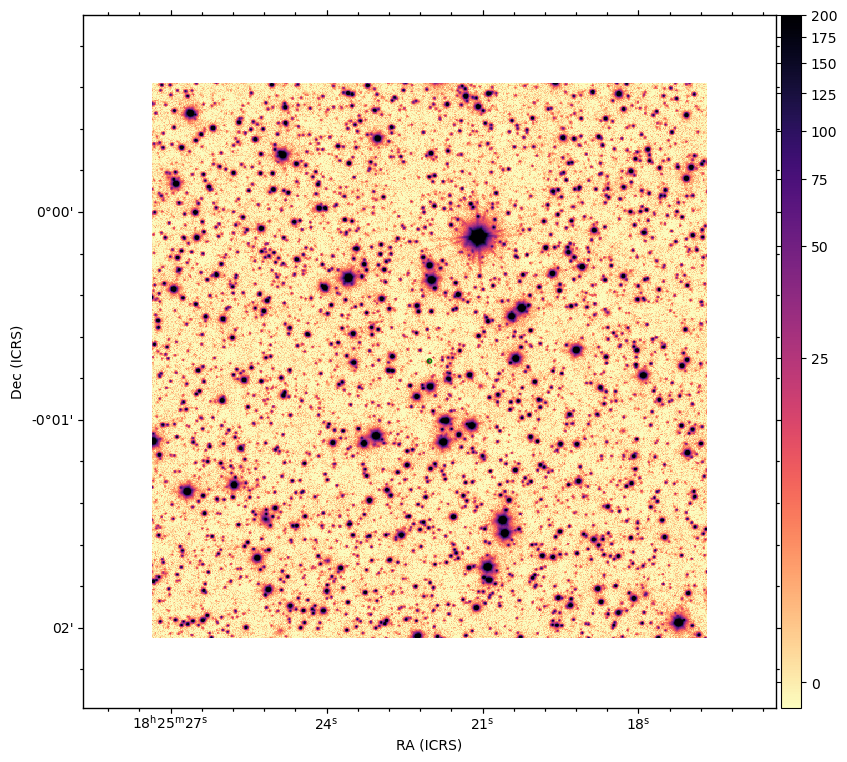

In [3]:
""" 
Create cutout around source for selecting stars for model. 
""" 

# Load the image and the WCS
hdulist_cut = fits.open(flname.split(".fits")[0] + "_astrocal.fits")[0]  # open the calibrated mos.fits file 
w = wcs.WCS(hdulist_cut.header)

# Make the cutout, including the WCS
size = (1000,1000) # cut out 1000 by 1000 pixels
cutout = Cutout2D(hdulist_cut.data, position=XRB_coo, size=size, wcs=w)
hdulist_cut.data = cutout.data

# Update the FITS header with the cutout WCS
hdulist_cut.header.update(cutout.wcs.to_header())

# Plot cutout image
gc = aplpy.FITSFigure(hdulist_cut)
gc.show_colorscale(cmap='magma_r',stretch='arcsinh',vmin=-1, vmax=200)

# Plot the XRB source coordinate and recenter on it
gc.show_circles(XRB_coo.ra.deg, XRB_coo.dec.deg, radius/3600., edgecolor='g', facecolor='none', alpha=1)
gc.recenter(XRB_coo.ra.deg, XRB_coo.dec.deg, radius=100/3600.)# degrees
gc.add_colorbar()

x_peak y_peak peak_value
------ ------ ----------
   912      0  936.38348
   664      1  988.81537
   514      2  791.05597
   478      3  8457.9141
   985      5  783.07349
   351     14  449.94489
   267     18  341.60019
   169     19  676.86517
   832     22  408.65445
   729     23   836.8606
   ...    ...        ...
   587    957  2456.0576
   532    961  709.34631
   565    976  2627.8069
   360    980  534.38806
   841    980  2660.6294
   606    981  1152.6345
   353    982  921.63074
   794    984  744.11963
   388    996  900.00018
   215    997    720.198
   727    999  778.22821
Length = 349 rows


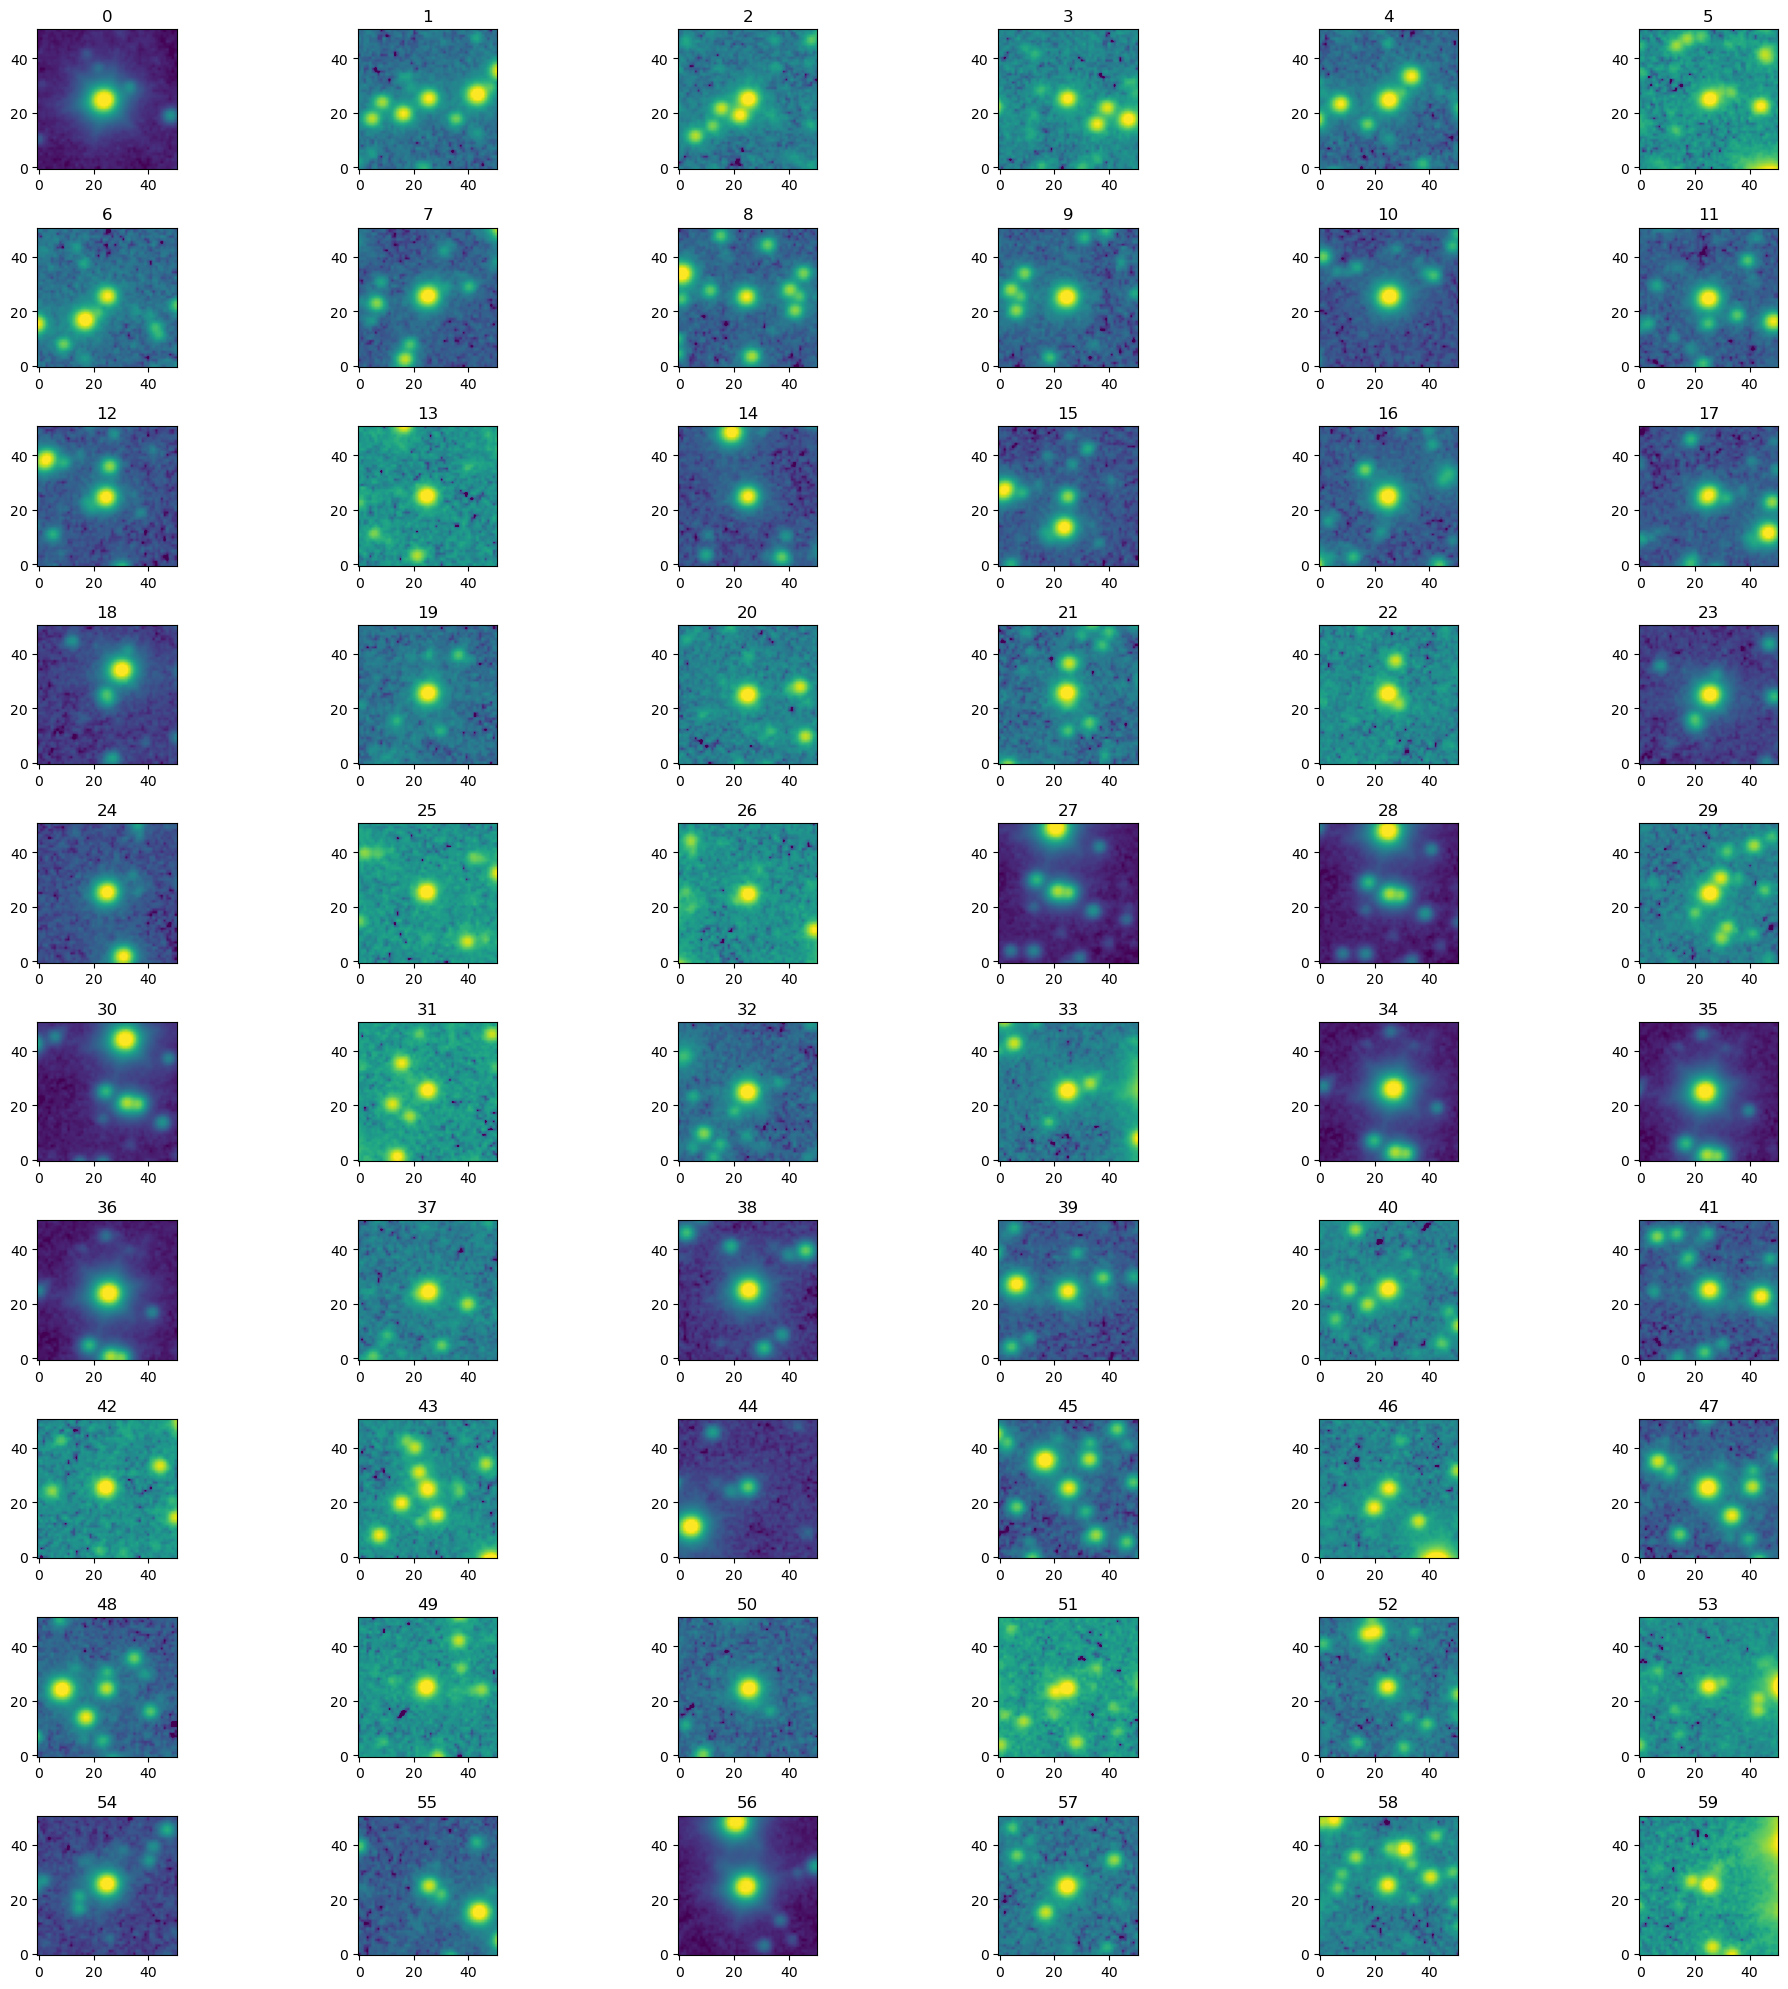

In [4]:
'''  
Cutout the brightest stars (> treshold) in the image above
and show a subset of the selected stars. 
'''

threshold = 300 # threshold value for selecting stars

# Identify stars
data = hdulist_cut.data
peaks_tbl = find_peaks(data, threshold=threshold)  
peaks_tbl['peak_value'].info.format = '%.8g'  # for consistent table output
print(peaks_tbl)  


# Create star cutouts while excluding stars close to the image boundary
size = 51 # create size x size pixel cutouts of stars
hsize = (size - 1) / 2
x = peaks_tbl['x_peak']  
y = peaks_tbl['y_peak']  
mask = ((x > hsize) & (x < (data.shape[1] -1 - hsize)) &
        (y > hsize) & (y < (data.shape[0] -1 - hsize)))  

# Create table of good star positions
stars_tbl = Table()
stars_tbl['x'] = x[mask]  
stars_tbl['y'] = y[mask]  

# Extract cutouts for selected stars
nddata = NDData(data=data)  
stars = extract_stars(nddata, stars_tbl, size=size)  

# Show a subset of the selected stars
nrows = 10
ncols = 6
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20), squeeze=True)
ax = ax.ravel()
for i in range(nrows * ncols):
    norm = simple_norm(stars[i], 'log', percent=99.)
    ax[i].imshow(stars[i], norm=norm, origin='lower', cmap='viridis')
    ax[i].set_title(i)
fig.tight_layout()    

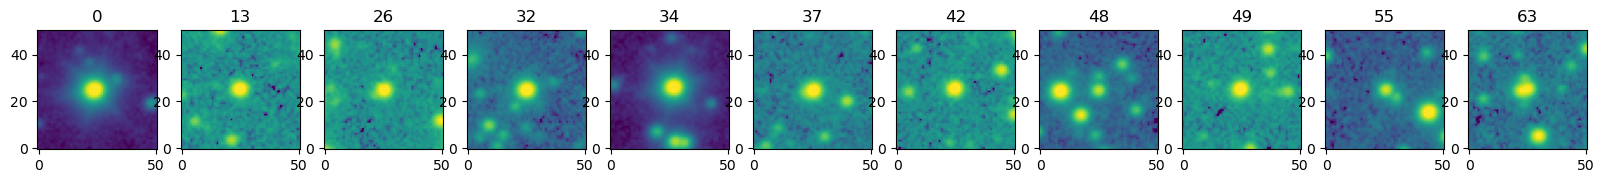

In [5]:
""" 
Select sample of good stars. 

The stars that we selected are already bright, 
but we need to select stars that are isolated and
where no artifacts are present in the images. 
We make the selection by inspecting the images above 
manually and adding the cutout indices in the list below. 
""" 

# Select stars
good_images = [0, 13, 26, 32, 34, 37, 42, 48, 49, 55, 63]
# size = 51
good_table = stars_tbl[good_images]
good_stars = extract_stars(nddata, good_table, size=size)  

# Display selection of stars
nrows = 1
ncols = len(good_images)
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20), squeeze=True)
ax = ax.ravel()
for i in range(nrows * ncols):
    norm = simple_norm(good_stars[i], 'log', percent=99.)
    ax[i].imshow(good_stars[i], norm=norm, origin='lower', cmap='viridis')
    ax[i].set_title(good_images[i])

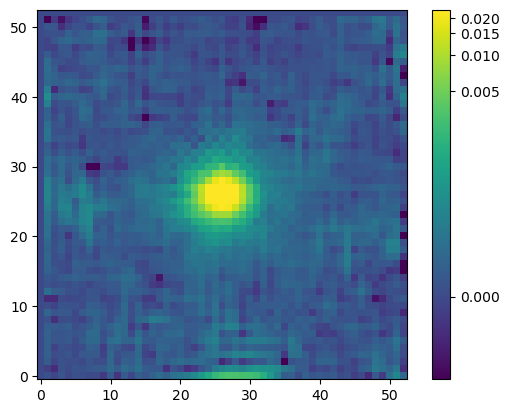

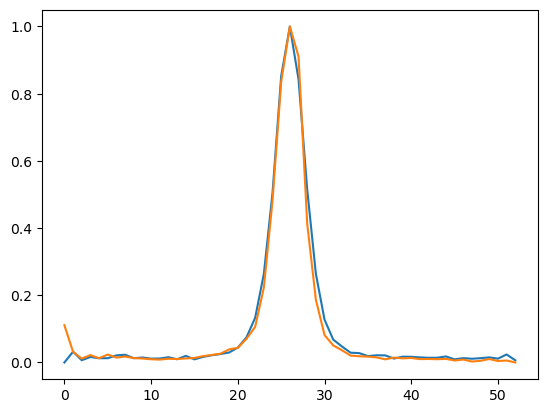

In [6]:
""" 
Build ePSF from selected stars.
""" 

# Construct ePSF
epsf_builder = EPSFBuilder(oversampling=1, maxiters=15, progress_bar=False)  
epsf, fitted_stars = epsf_builder(good_stars)  

# Show the constructed ePSF
norm = simple_norm(epsf.data, 'log', percent=99.)
plt.imshow(epsf.data, norm=norm, origin='lower', cmap='viridis')
plt.colorbar()
plt.show()

# Plot the intersections of the constructed ePSF
plt.plot(np.sum(epsf.data, axis=0)/max(np.sum(epsf.data, axis=0)))
plt.plot(np.sum(epsf.data, axis=1)/max(np.sum(epsf.data, axis=1)))
plt.show()

## Section 3: Apply PSF <a class="anchor" id="section3"></a>
We are now ready to apply PSF with the created ePSF to the area around our target.

In [7]:
""" 
Create even smaller cutout around source to apply PSF on. 
(otherwise it takes very long and we don't care about the other stars)
""" 

# Load the image and the WCS
hdulist_cut = fits.open(flname.split(".fits")[0] + "_astrocal.fits")[0]  # open the calibrated mos.fits file 
w = wcs.WCS(hdulist_cut.header)

# Make the cutout, including the WCS
size = (30,30)  # cut out 50 by 50 pixels
cutout = Cutout2D(hdulist_cut.data, position=XRB_coo, size=size, wcs=w)
hdulist_cut.data = cutout.data

# Update the FITS header with the cutout WCS
hdulist_cut.header.update(cutout.wcs.to_header())

In [8]:
""" 
Do PSF photometry. The photutils documentation 
provides more information about the used algorithm and 
parameters: https://photutils.readthedocs.io/en/stable/psf.html#
""" 

sigma_psf = 2. 
image = hdulist_cut.data

# Instatniate algorithm to perform PSF
bkgrms = MADStdBackgroundRMS()
std = bkgrms(image)
iraffind = IRAFStarFinder(threshold=3.*std,
                          fwhm=sigma_psf * gaussian_sigma_to_fwhm,
                          minsep_fwhm=0.01, roundhi=5.0, roundlo=-5.0,
                          sharplo=0.0, sharphi=2.0)
daogroup = DAOGroup(2.0 * sigma_psf * gaussian_sigma_to_fwhm)
mmm_bkg = MMMBackground()
fitter = LevMarLSQFitter()
psf_model = epsf # use the ePSF that we created
photometry = IterativelySubtractedPSFPhotometry(finder=iraffind,
                                                group_maker=daogroup,
                                                bkg_estimator=mmm_bkg,
                                                psf_model=psf_model,
                                                fitter=LevMarLSQFitter(),
                                                niters=1, fitshape=(11, 11))

# Apply PSF to the cutout image
result_tab = photometry(image=image)
residual_image = photometry.get_residual_image()

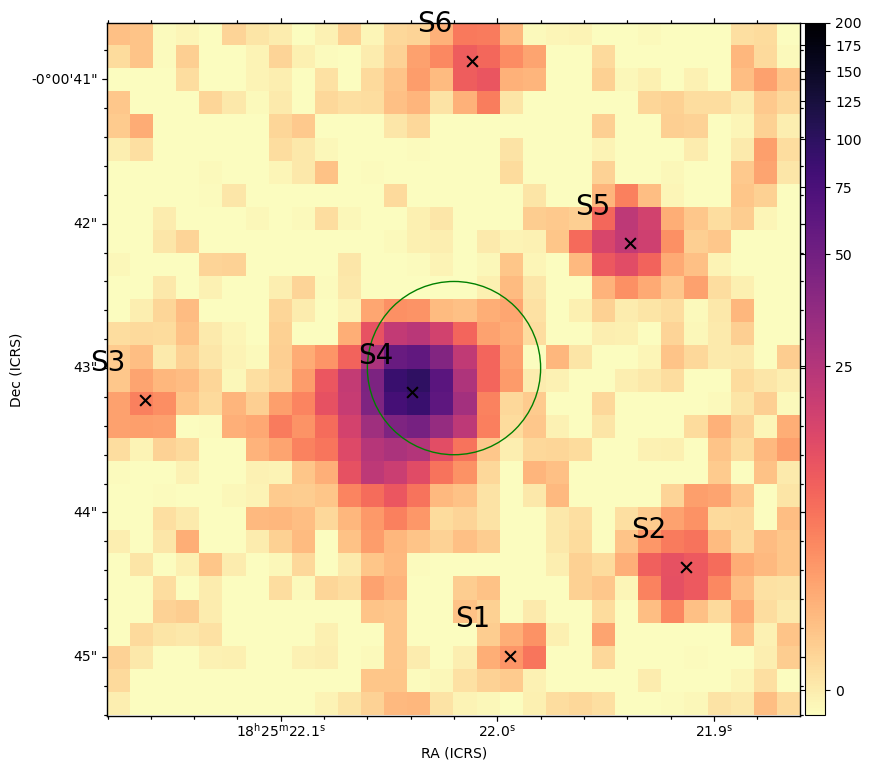

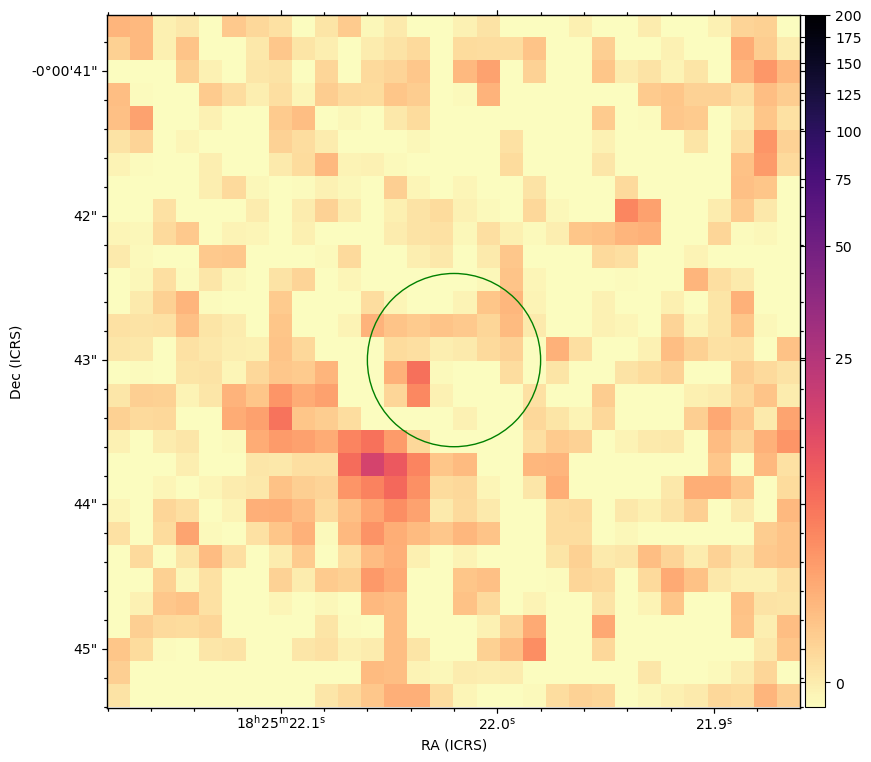

In [9]:
""" 
Plot original image around the target star and 
the position of the by PSF detected stars. We also 
plot the residual image to see if star substraction 
went okay.
""" 

chart_size = 8 # Half width of the finder chart in arcseconds; default: 8
label_size = 20 # Size of the labels of the counterparts, error circles and scale bar; default: 10
counterpart_color = 'k' # Color of counterpart markers and their labels; default: 'r'
label_pos = (chart_size / 10.) * 0.32/3600

# Update data and header
hdulist_cut.data = image
hdulist_cut.header.update(cutout.wcs.to_header())
w = wcs.WCS(hdulist_cut.header)

# Plot original image with detected stars
gc = aplpy.FITSFigure(hdulist_cut)
gc.show_colorscale(cmap='magma_r',stretch='arcsinh',vmin=-1, vmax=200)
gc.show_circles(XRB_coo.ra.deg, XRB_coo.dec.deg, radius/3600., edgecolor='g', facecolor='none', alpha=1)
gc.add_colorbar()
gc.savefig(figname_centroids) 

# Plot location of detected counerparts
for i in range(len(result_tab)):
    ra, dec = w.wcs_pix2world(result_tab[i][1], result_tab[i][3], 0, ra_dec_order=True)
    gc.show_markers(float(ra), float(dec), edgecolor=counterpart_color, facecolor=counterpart_color, marker='x', s=60, alpha=1)
    gc.add_label(float(ra) + label_pos, float(dec) + label_pos, 'S'+str(result_tab[i][6]), size=label_size, color=counterpart_color)

# Plot residual image
hdulist_res = hdulist_cut
hdulist_res.data = residual_image
hdulist_res.header.update(cutout.wcs.to_header())
gc = aplpy.FITSFigure(hdulist_res)
gc.show_colorscale(cmap='magma_r',stretch='arcsinh',vmin=-1, vmax=200)
gc.show_circles(XRB_coo.ra.deg, XRB_coo.dec.deg, radius/3600., edgecolor='g', facecolor='none', alpha=1)
gc.add_colorbar()
gc.savefig(figname_residual) 

In [10]:
""" 
Look at output Table 
""" 
display(result_tab)

x_0,x_fit,y_0,y_fit,flux_0,flux_fit,id,group_id,flux_unc,x_0_unc,y_0_unc,iter_detected
float64,float64,float64,float64,float64,float64,int32,int32,float64,float64,float64,int32
16.95830031745963,16.939325143928873,2.2547822021263344,2.0880429944302095,40.970992043831735,62.867994109903755,1,1,15.069805913318643,0.5835683593690444,0.5310807867283658,1
24.359361386361726,24.53857003361071,5.928125547564909,5.940761839190507,203.77997621265584,233.53031347930593,2,1,14.991220596234662,0.15472613612484945,0.13966266481336878,1
1.3597663543062581,1.1438777842003711,13.13623820428034,13.161294774282402,92.96178089849914,115.95830579856592,3,2,11.889155208304194,0.2798421496725902,0.21822025707555925,1
12.77699482648115,12.706046763953964,13.624624044980473,13.485524703197033,1593.6882673412447,1581.174613781567,4,3,25.40304136460449,0.03902425568054085,0.03402728422463492,1
22.04871998527127,22.130358598017295,20.015883294187734,19.9387856046069,220.25328721095062,318.76147468315656,5,4,16.316973677197534,0.12463311787847114,0.11136700408249221,1
15.590045547680699,15.270277611696407,27.67075973106173,27.851457150649903,115.15774636701659,196.59462576267714,6,5,15.785257587153737,0.19394262550691813,0.19425511954152255,1


## Section 4: Extract magnitude and flux <a class="anchor" id="section4"></a>

In [11]:
'''
Using the above image and table, select the id of
the star that we want to extract magnitude from 
and convert pixel value to magnitude. 

Uncertanties in the pixel flux are calculated by taking 
the square root of the covariance matrix (gives the 
standard deviations)

We use the zeropoint offset and extinction that were
calculated by the regular FSRED post processing notebook
to obtain the corrected magnitudes. 

In addition, we retrieve the pixel position of the sources
in the original image to later on add them in the correct
way to the updated cat file. 
'''

star_list = [4, 5]

# Retrieve values to determine corrected magnitude
header = fits.getheader(flname.split(".fits")[0] + "_astrocal.fits")
zeropoint = header['MAGZP']
offset_zp = -0.0474167842
zp_err = 0.0040912846456502
An_ext = 0.3284916201
A_err = 0.005505446147

# Convert pixel value to magnitude
mags_list = []
magserr_list = []
magcal_list = []
magdered_list = []
tot_err_list = []
for n, star_id in enumerate(star_list): 
    flux_count = result_tab[result_tab['id']==star_id]['flux_fit'].value[0]
    magnitude = zeropoint - 2.5 * np.log10(flux_count) # https://mirametrics.com/help/mira_al_8/source/magnitude_calculations.htm
    mags_list.append(magnitude)
    flux_err = result_tab[result_tab['id']==star_id]['flux_unc'].value[0]
    mag_err = flux_err / flux_count * 2.5 / np.log(10)  # TODO is dit oK? 
    magserr_list.append(mag_err)

    # Calibrate and de-redden magnitude 
    mag_cal = magnitude - offset_zp
    magcal_list.append(mag_cal)
    mag_dered = mag_cal - An_ext
    magdered_list.append(mag_dered)
    tot_err =  np.sqrt(mag_err**2 + zp_err **2 + A_err**2)
    tot_err_list.append(tot_err)

# Convert position to initial pixel coordinate system
RA_list = []
DEC_list = []
x_list = []
y_list = []
hdulist_cut = fits.open(flname.split(".fits")[0] + "_astrocal.fits")[0]  # open the calibrated mos.fits file 
w_old = wcs.WCS(hdulist_cut.header)
for n, star_id in enumerate(star_list): 
    RA, DEC = w.wcs_pix2world(result_tab[result_tab['id']==star_id]['x_fit'], result_tab[result_tab['id']==star_id]['y_fit'], 0, ra_dec_order=True)
    x, y = w_old.wcs_world2pix(RA, DEC, 1, ra_dec_order=True)
    RA_list.append(RA)
    DEC_list.append(DEC)
    x_list.append(x)
    y_list.append(y)

In [12]:
""" 
Calculate flux density based on AB magnitude system
using     m_AB = -2.5 log10(F_nu) - 48.60 
and       F_lamb = F_nu * c / lamb_eff
and convert this flux density to flux. 
""" 

# Calculate flux density 
if band == 'J':
    W_eff = 2214.62 # A
    l_eff = 12287.26 # A
elif band == 'H':
    W_eff = 2769.45 # A 
    l_eff = 16039.55 # A
elif band == 'Ks':
    W_eff = 3163.40 # A
    l_eff = 21315.89 # A

c = 2.9979e18 # A/s
F_lamb_list = []
F_lamb_err_list = []
Flux_list = []
Flux_err_list = []
for i, mag in enumerate(magdered_list): 
    F_nu = 10**(-(mag+48.60)/2.5) # erg/s/cm2/Hz   
    F_lamb = F_nu * c / l_eff**2 # erg/s/cm2/A
    Flux = W_eff * F_lamb 
    
    F_lamb_list.append(F_lamb)
    Flux_list.append(Flux)

    # Propagate the error on the flux density
    F_nu_err = tot_err_list[i] * F_nu * np.log(10)/2.5
    F_lamb_err = F_nu_err * c / l_eff**2
    F_lamb_err_list.append(F_lamb_err)
    
    # Propagate the error on the flux  
    Flux_err = F_lamb_err * W_eff
    Flux_err_list.append(Flux_err)


In [13]:
"""
Display all important numbers for the
deblended sources
"""

for n, star_id in enumerate(star_list):
    print('>>> star ' + str(star_id) + ':')
    print('RA, Dec: ' + str(RA_list[n][0]) + ', ' + str(DEC_list[n][0]))
    print('\tRaw mag: ' + str(mags_list[n]) + ' +/- ' + str(magserr_list[n]))
    print('\tCalibrated mag: ' + str(magcal_list[n]))
    print('\tCalibrated & dereddened mag: ' +  str(magdered_list[n]))
    print('\tTotal mag error: ' + str(tot_err_list[n]))
    print('\tSpectral flux density per unit wavelength (erg/s/cm2/A): ' + str(F_lamb_list[n]) + ' +/- ' + str(F_lamb_err_list[n]))
    print('\tFlux (erg/s/cm2): ' + str(Flux_list[n]) + ' +/- ' + str(Flux_err_list[n]))

>>> star 4:
RA, Dec: 276.3418302428678, -0.01199127867852335
	Raw mag: 18.71655041749337 +/- 0.017443362346019592
	Calibrated mag: 18.76396720169337
	Calibrated & dereddened mag: 18.43547558159337
	Total mag error: 0.01874351720632455
	Spectral flux density per unit wavelength (erg/s/cm2/A): 1.7874855929041346e-17 +/- 3.085810975062728e-19
	Flux (erg/s/cm2): 4.950351975268355e-14 +/- 8.545999204887471e-16
>>> star 5:
RA, Dec: 276.34141138473717, -0.011704467442078018
	Raw mag: 20.455335431674342 +/- 0.055577384597771985
	Calibrated mag: 20.50275221587434
	Calibrated & dereddened mag: 20.174260595774342
	Total mag error: 0.05599905558183917
	Spectral flux density per unit wavelength (erg/s/cm2/A): 3.60353333909356e-18 +/- 1.8585956962894566e-19
	Flux (erg/s/cm2): 9.979805405952658e-15 +/- 5.147287851088835e-16


In [14]:
"""
Write important numbers to text file.
"""

with open(txtname, 'w') as f:
    # Write source information
    f.write('Source information:\n')
    f.write('Source: ' + source + '\n')
    f.write('Coordinates: ' + coords + '\n')
    f.write('Observation number: ' + obs + '\n')
    f.write('Band: ' + band + '\n')
    f.write('' + '\n')

    # Write information about deblended counterparts
    f.write("Detected counterparts:" + '\n')
    for n, star_id in enumerate(star_list):
        f.write('>>> star ' + str(star_id) + ':' + '\n')
        f.write('RA, Dec: ' + str(RA_list[n][0]) + ', ' + str(DEC_list[n][0]) + '\n')
        f.write('\tRaw mag: ' + str(mags_list[n]) + ' +/- ' + str(magserr_list[n]) + '\n')
        f.write('\tCalibrated mag: ' + str(magcal_list[n]) + '\n')
        f.write('\tCalibrated & dereddened mag: ' +  str(magdered_list[n]) + '\n')
        f.write('\tTotal mag error: ' + str(tot_err_list[n]) + '\n')
        f.write('\tSpectral flux density per unit wavelength (erg/s/cm2/A): ' + str(F_lamb_list[n]) + ' +/- ' + str(F_lamb_err_list[n]) + '\n')
        f.write('\tFlux (erg/s/cm2): ' + str(Flux_list[n]) + ' +/- ' + str(Flux_err_list[n]) + '\n')
        f.write('')
f.close()

In [15]:
'''
Add deblended sources to a new cat file and
merge this with the original cat file. 
'''

# Open original cat file 
data = fits.getdata(flname.split(".mos")[0] + "_calibrated.mos.fits.cat")

# Initiate new cat file in same format as original cat file
newcol_list = []
for n, i in enumerate(data.columns):
    a = np.zeros(len(star_list))
    col = fits.Column(name=i.name, format='1E', array=a)
    newcol_list.append(col)
hdu_manual = fits.BinTableHDU.from_columns(newcol_list)

# Save position and flux to new cat file
for n, i in enumerate(star_list): 
    hdu_manual.data[n]['X_IMAGE'] = x_list[n]
    hdu_manual.data[n]['Y_IMAGE'] = y_list[n]
    hdu_manual.data[n]['MAG_AUTO'] = magdered_list[n]
    hdu_manual.data[n]['MAGERR_AUTO'] = tot_err_list[n]
hdu_manual.writeto(flname.split(".mos.fits.cat")[0] + "_newsources.mos.fits.cat", overwrite=True)

# Merge original and new cat file
with fits.open(flname.split(".mos")[0] + "_calibrated.mos.fits.cat") as hdul1:
    with fits.open(flname.split(".mos.fits.cat")[0] + "_newsources.mos.fits.cat") as hdul2:
        nrows1 = hdul1[1].data.shape[0]
        nrows2 = hdul2[1].data.shape[0]
        nrows = nrows1 + nrows2
        hdu_merged = fits.BinTableHDU.from_columns(hdul1[1].columns, nrows=nrows)
        for colname in hdul1[1].columns.names:
            if colname == 'VIGNET': # VIGNET requires a different format
                continue
            hdu_merged.data[colname][nrows1:] = hdul2[1].data[colname]

# Safe merged cat file            
hdu_merged.writeto(flname.split(".mos.fits.cat")[0] + "_deblended.mos.fits.cat", overwrite=True)